# LORA

- Full finetuning required all the weights to be saved: More memory footprint required.
- LORA: Weights around attention computation or all the weights
   - Adds new set of weights: Low rank tensors
   - Input and Output dimensions match with W
   - Inner dimensions are smaller so effective size is smaller
   - Cost loading of this finetuned models is very low
   - So easily switch or load them on the fly

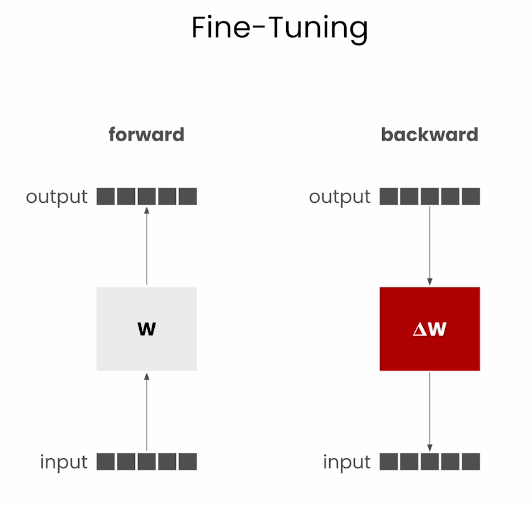
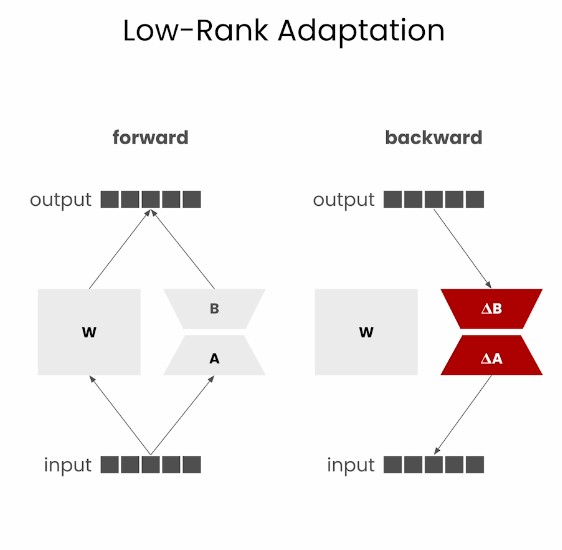

## Toy Language model

In [4]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

torch.manual_seed(42)

In [5]:
class TestModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, hidden_size) # embedding layer: maps input token ids to hidden states
        self.linear = torch.nn.Linear(hidden_size, hidden_size) # projects that embedding to another embedding
        self.lm_head = torch.nn.Linear(hidden_size, 10) # lm head layer: produces final logit -> No attention
    
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

In [6]:
# set a reasonably large hidden size to illustrate the small fraction of
# params needed to be added for LoRA
hidden_size = 1024
model = TestModel(hidden_size)

In [7]:
print(model)

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): Linear(in_features=1024, out_features=1024, bias=True)
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)


### Simple Vocab

In [8]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

# toy example of a detokenizer. 
# The vocabulary only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

### generate token

In [9]:
# this is the same generation step as we saw in lesson 2 (batching)
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [10]:
# generate one token
next_token = generate_token(model, input_ids=input_ids)[0]
next_token

'magenta'

## LORA

In [11]:
# dummy input tensor
# shape: (batch_size, sequence_length, hidden_size)
X = torch.randn(1, 8, 1024)

In [12]:
X

tensor([[[ 0.4333, -1.3517, -0.8030,  ..., -1.0855,  3.2371, -1.4757],
         [ 0.9492,  0.5531,  0.8596,  ...,  1.1852, -0.9520,  1.4142],
         [-1.0038, -0.1944, -0.1730,  ...,  0.8175, -2.7022,  1.8578],
         ...,
         [ 0.4469,  2.3303,  1.6584,  ...,  0.6878, -1.8856, -1.2131],
         [ 1.2963,  2.1563, -1.4809,  ...,  0.4633, -0.4596, -1.7364],
         [ 0.8114, -0.1914, -0.0934,  ...,  0.4458,  1.4660, -0.1785]]])

In [13]:
# LoRA A and B tensors
# A has shape (hidden_size, rank)
# B has shape (rank, hidden_size)
lora_a = torch.randn(1024, 2)
lora_b = torch.randn(2, 1024)

In [14]:
W = model.linear.weight

In [15]:
W.shape

torch.Size([1024, 1024])

In [16]:
W2 = lora_a @ lora_b

In [17]:
W2.shape

torch.Size([1024, 1024])

In [18]:
# Compare number of elements of A and B with number of elements of W
# W here has shape (hidden_size, hidden_size)
lora_numel = lora_a.numel() + lora_b.numel()
base_numel = W.numel()
print("|A+B| / |W|:", lora_numel / base_numel)

|A+B| / |W|: 0.00390625


In [19]:
lora_a.numel() # 1024 * 2

2048

## Computation

In [20]:
# compute the output of X @ W (the original linear layer)
base_output = model.linear(X)

# compute the output of X @ A @ B (the added lora adapter)
lora_output = X @ lora_a @ lora_b

# sum them together
total_output = base_output + lora_output

# output should have the same shape as the original output:
# (batch_size, sequence_length, hidden_size)
total_output.shape

torch.Size([1, 8, 1024])

In [21]:
base_output.shape, lora_output.shape

(torch.Size([1, 8, 1024]), torch.Size([1, 8, 1024]))

In [22]:
class LoraLayer(torch.nn.Module):
    def __init__(self, base_layer, r):
        super().__init__()
        self.base_layer = base_layer
        
        d_in, d_out = self.base_layer.weight.shape
        self.lora_a = torch.randn(d_in, r)
        self.lora_b = torch.randn(r, d_out) 
        
    def forward(self, x):
        y1 = self.base_layer(x)
        y2 = x @ self.lora_a @ self.lora_b
        return y1 + y2

In [23]:
# wrap the linear layer of our toy model, use rank 2
lora_layer = LoraLayer(model.linear, 2)
lora_layer(X).shape

torch.Size([1, 8, 1024])

In [24]:
model.linear = lora_layer

In [25]:
model

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): LoraLayer(
    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

In [26]:
next_token = generate_token(model, input_ids=input_ids)
next_token[0]

'indigo'